In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [37]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [38]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [39]:
train.nunique()
train.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Bostandyeff, Mr. Guentcho",male,CA. 2343,C23 C25 C27,S
freq,1,577,7,4,644


## Categorical/Discretely valued VS [Survived]
查看(分類型/離散型數據)與(生存率)的重要性 

In [40]:
train[["Pclass","Survived"]].groupby("Pclass",as_index=False).mean()

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [41]:
train[["Sex","Survived"]].groupby("Sex",as_index=False).mean()

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [42]:
train[["Embarked","Survived"]].groupby("Embarked",as_index=False).mean().sort_values(['Survived'], ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [43]:
train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean()

,SibSp,Survived
0,0,0.345395
1,1,0.535885
2,2,0.464286
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


##### sibsp =0 cnt =608   
##### sibsp =1 cnt =209 
##### sibsp =2 cnt =28 
##### sibsp =3 cnt =16 
##### sibsp =4 cnt =18   
##### sibsp =5 cnt =5  
##### sibsp =8 cnt =7 

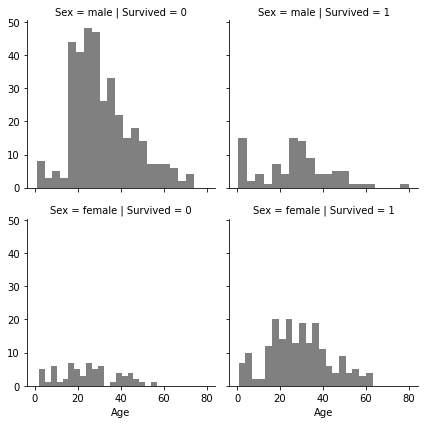

In [44]:
import seaborn as sns
grid = sns.FacetGrid(train, col='Survived', row='Sex')
grid.map(plt.hist, 'Age', bins=20, color='gray')
plt.show()

## 大多數年輕男性未存活

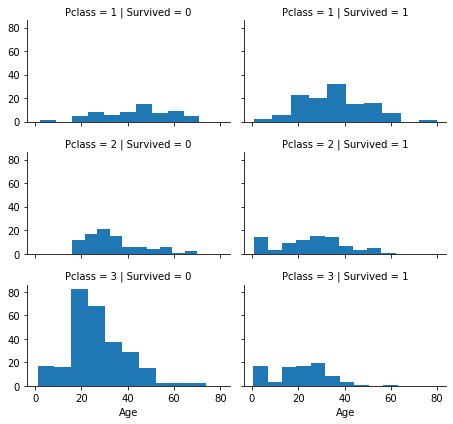

In [45]:
grid = sns.FacetGrid(train, col='Survived', row='Pclass', height=2, aspect=1.6) # aspect:長寬比
grid.map(plt.hist, 'Age')
plt.show()

## Pclass=3 且小於40歲的生存率較低

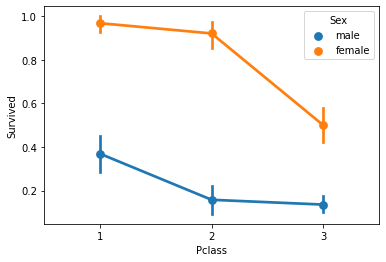

In [46]:
sns.pointplot(data=train, x='Pclass', y='Survived', hue='Sex')

#### 將Object型式改為int64 


In [47]:
for dataset in [train, test]:
    dataset['Sex'] = dataset['Sex'].map( {'male':1, 'female':0} )
    
for dataset in [train, test]:
    dataset['Embarked'] = dataset['Embarked'].map( {'Q':1, 'S':2, 'C':3} )

In [48]:
train = train.drop(['PassengerId', 'Name', 'Ticket', 'Cabin',"Parch","SibSp","Embarked","Fare","Age"], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Cabin',"Parch","SibSp","Embarked","Fare","Age"], axis=1)

In [49]:
train

,Survived,Pclass,Sex
0,0,3,1
1,1,1,0
2,1,3,0
3,1,1,0
4,0,3,1
...,...,...,...
886,0,2,1
887,1,1,0
888,0,3,0
889,1,1,1


In [50]:
import statsmodels.imputation.mice as mice
imp_train_mice = mice.MICEData(train)
train_mice = imp_train_mice.data
imp_test_mice = mice.MICEData(test)
test_mice = imp_test_mice.data

#### 空值資料填入(自動)
#### EX:888 AGE

In [51]:
train_mice

,Survived,Pclass,Sex
0,0,3,1
1,1,1,0
2,1,3,0
3,1,1,0
4,0,3,1
...,...,...,...
886,0,2,1
887,1,1,0
888,0,3,0
889,1,1,1


In [52]:
X_train = train_mice.iloc[:, 1:]
Y_train = train_mice.iloc[:, 0]

In [53]:
from sklearn.preprocessing import Normalizer
Normalizer = Normalizer()
X_train = Normalizer.fit_transform(X_train)
X_test = Normalizer.fit_transform(test_mice)

In [54]:
from sklearn.ensemble import RandomForestClassifier
RFC = RandomForestClassifier(random_state=2,n_estimators=250,min_samples_split=20,oob_score=True)
RFC.fit(X_train, Y_train)
Y_pred = RFC.predict(X_test)
randomfroest_score = round(RFC.score(X_train, Y_train) * 100, 2)
randomfroest_score

78.68

In [55]:
index = pd.RangeIndex(start =892, stop =1310 , step =1)
submission = pd.DataFrame(
{"PassengerId" : index ,
 "Survived"    : Y_pred}
)
submission.to_csv("titanic90.csv", index= False)